In [1]:
%load_ext autoreload
%autoreload 2

# 2D Navier Stokes lid-driven flow

Benchmark on the 2D Navier Stokes lid-driven flow as proposed in the PINNACLE benchmark paper (https://arxiv.org/pdf/2306.08827) (see Appendix B11: (**NS2d-C**)).

We dig through the PINNACLE code database to retrieve the experimental setting (number of collocation points, number of iterations, ...) as well as the reference values of the solution.

In [2]:
seed = 1

In [3]:
import numpy as np

# from PINNACLE
DEFAULT_NUM_DOMAIN_POINTS = 8192 // 10
DEFAULT_NUM_BOUNDARY_POINTS = 2048 // 10

ref_data = np.loadtxt("lid_driven_a4.dat", comments="%").astype(np.float32)

In [4]:
nu = 1 / 100
a = 4

**Summary:**
- [DeepXDE](#DeepXDE)
- [jinns](#jinns)
- [PINA](#PINA)
- [Comparisons](#Comparisons)

## DeepXDE


We use the JAX backend.

Compiling model...
'compile' took 0.000191 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [5.22e-04, 3.31e-02, 5.92e-03, 2.56e-01, 4.57e-03, 1.78e-02, 1.09e-02, 0.00e+00]    [5.22e-04, 3.31e-02, 5.92e-03, 2.56e-01, 4.57e-03, 1.78e-02, 1.09e-02, 0.00e+00]    []  
1000      [4.33e-03, 2.70e-03, 1.33e-03, 4.49e-03, 5.66e-03, 7.77e-04, 8.52e-04, 1.10e-05]    [4.33e-03, 2.70e-03, 1.33e-03, 4.49e-03, 5.66e-03, 7.77e-04, 8.52e-04, 1.10e-05]    []  
2000      [9.71e-04, 1.33e-03, 3.45e-03, 1.25e-03, 1.50e-03, 1.33e-03, 1.37e-03, 1.85e-04]    [9.71e-04, 1.33e-03, 3.45e-03, 1.25e-03, 1.50e-03, 1.33e-03, 1.37e-03, 1.85e-04]    []  
3000      [1.47e-03, 7.38e-04, 4.16e-04, 3.41e-04, 9.39e-04, 1.13e-03, 7.09e-04, 2.57e-05]    [1.47e-03, 7.38e-04, 4.16e-04, 3.41e-04, 9.39e-04, 1.13e-03, 7.09e-04, 2.57e-05]    []  
4000      [7.

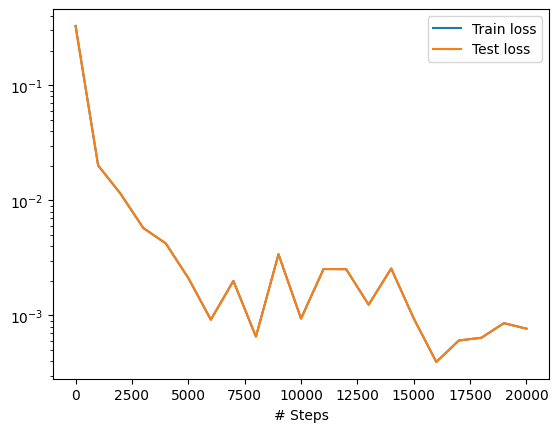

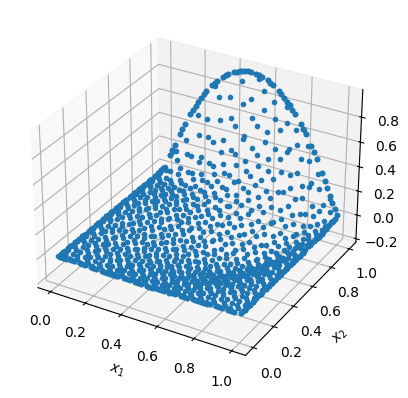

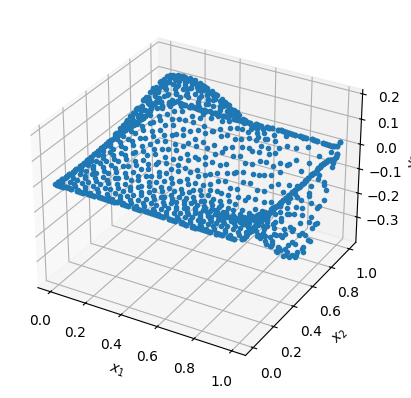

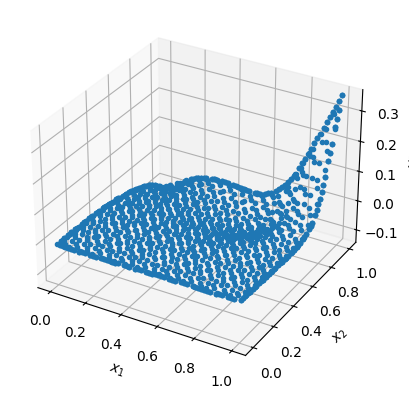

In [7]:
import os
os.environ["DDE_BACKEND"]="pytorch"
import deepxde as dde

# Determinism may reduce performance in DeepXDE (see doc) but needs to
# be set for a fair comparison with Jinns
# https://deepxde.readthedocs.io/en/stable/modules/deepxde.html#deepxde.config.set_random_seed
dde.config.set_random_seed(seed)


# PDE (Pytorch)
def ns_pde(x, u):
            u_vel, v_vel, _ = u[:, 0:1], u[:, 1:2], u[:, 2:]
            u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
            u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
            u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
            u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

            v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
            v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
            v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
            v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

            p_x = dde.grad.jacobian(u, x, i=2, j=0)
            p_y = dde.grad.jacobian(u, x, i=2, j=1)

            momentum_x = (u_vel * u_vel_x + v_vel * u_vel_y + p_x - nu * (u_vel_xx + u_vel_yy))
            momentum_y = (u_vel * v_vel_x + v_vel * v_vel_y + p_y - nu * (v_vel_xx + v_vel_yy))
            continuity = u_vel_x + v_vel_y

            return [momentum_x, momentum_y, continuity]
# PDE (JAX)
# def ns_pde(x, u):
#     u_val, u_fn = u
#     u_vel, v_vel, _ = u_val[:, 0:1], u_val[:, 1:2], u_val[:, 2:]
#     u_vel_x, _ = dde.grad.jacobian(u, x, i=0, j=0)
#     u_vel_y, _ = dde.grad.jacobian(u, x, i=0, j=1)
#     u_vel_xx, _ = dde.grad.hessian(u, x, component=0, i=0, j=0)
#     u_vel_yy, _ = dde.grad.hessian(u, x, component=0, i=1, j=1)

#     v_vel_x, _ = dde.grad.jacobian(u, x, i=1, j=0)
#     v_vel_y, _ = dde.grad.jacobian(u, x, i=1, j=1)
#     v_vel_xx, _ = dde.grad.hessian(u, x, component=1, i=0, j=0)
#     v_vel_yy, _ = dde.grad.hessian(u, x, component=1, i=1, j=1)

#     p_x, _ = dde.grad.jacobian(u, x, i=2, j=0)
#     p_y, _ = dde.grad.jacobian(u, x, i=2, j=1)

#     momentum_x = (u_vel * u_vel_x + v_vel * u_vel_y + p_x - nu * (u_vel_xx + u_vel_yy))
#     momentum_y = (u_vel * v_vel_x + v_vel * v_vel_y + p_y - nu * (v_vel_xx + v_vel_yy))
#     continuity = u_vel_x + v_vel_y

#     return [momentum_x, momentum_y, continuity]

bbox=[0, 1, 0, 1]
geom = dde.geometry.Rectangle(xmin=[bbox[0], bbox[2]], xmax=[bbox[1], bbox[3]])
def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], bbox[3])

def boundary_not_top(x, on_boundary):
    return on_boundary and not np.isclose(x[1], bbox[3])
            
bc1 = dde.icbc.DirichletBC(geom, lambda x: a * x[:, 0:1] * (1 - x[:, 0:1]), boundary_top, 0)
bc2 = dde.icbc.DirichletBC(geom, lambda _: 0, boundary_top, 1)
bc3 = dde.icbc.DirichletBC(geom, lambda _: 0, boundary_not_top, 0)
bc4 = dde.icbc.DirichletBC(geom, lambda _: 0, boundary_not_top, 1)
bc5 = dde.icbc.PointSetBC(np.array([[0, 0]]), np.array([[0]]), 2)




data = dde.data.PDE(
    geom,
    ns_pde,
    [bc1, bc2, bc3, bc4, bc5],
    num_domain=DEFAULT_NUM_DOMAIN_POINTS,
    num_boundary=DEFAULT_NUM_BOUNDARY_POINTS,
    # train_distribution="uniform" # this is the default
    # num_test=None # this is the Default, we perform a evaluation callback on the same dataset as the training (see the test column in the training log)
)
net = dde.nn.FNN([2] + [100] * 5 + [3], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## jinns

In [5]:
import jax
import equinox as eqx
import jinns
import jax.numpy as jnp
from jax import grad, vmap, random
import optax
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(seed)

In [6]:
eqx_list = (
    (eqx.nn.Linear, 2, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 3)
)
key, subkey = random.split(key)
u_pinn, init_nn_params_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2)

In [7]:
n = DEFAULT_NUM_DOMAIN_POINTS
nb = DEFAULT_NUM_BOUNDARY_POINTS
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
method = "grid" # equals "uniform" in deepXDE, while "uniform" in jinns equals "pseudo" in deepXDE

train_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    method=method,
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/data/_DataGenerators.py:434: UserWarning: Grid sampling is requested in dimension 2 with a non perfect square dataset size (self.n = 819). Modifying self.n to self.n = 841.
  warnings.warn(


In [9]:
# Init parameters for NN and equation
init_params_pinn = jinns.parameters.Params(
    nn_params=init_nn_params_pinn,
    eq_params={
        "nu":nu
    }
)

In [10]:
from jinns.loss import PDEStatio

class NavierStokes2DStatio(PDEStatio):
    def equation(self, x, u_p, params):
        u_ = lambda x, params: u_p(x, params)[0:2]
        p_ = lambda x, params: u_p(x, params)[2]

        ux = lambda x, params: u_(x, params)[0]
        uy = lambda x, params: u_(x, params)[1]
    
        dux_dx = lambda x: grad(ux, 0)(x, params)[0]
        dux_dy = lambda x: grad(ux, 0)(x, params)[1]
    
        duy_dx = lambda x: grad(uy, 0)(x, params)[0]
        duy_dy = lambda x: grad(uy, 0)(x, params)[1]

        dp_dx = lambda x: grad(p_)(x, params)[0]
        dp_dy = lambda x: grad(p_)(x, params)[1]


        return jnp.array(
            [
                ux(x, params) * dux_dx(x) + uy(x, params) * dux_dy(x) + dp_dx(x)
                    - params.eq_params["nu"] * jinns.loss.laplacian_rev(x, lambda x, params: ux(x, params), params, eq_type="statio_PDE"),
                ux(x, params) * duy_dx(x) + uy(x, params) * duy_dy(x) + dp_dy(x)
                    - params.eq_params["nu"] * jinns.loss.laplacian_rev(x, lambda x, params: uy(x, params), params, eq_type="statio_PDE"),
                dux_dx(x) + duy_dy(x), # could have used jinns.loss.divergence_rev but we save computational resources here
            ]
        )

In [11]:
ns_loss = NavierStokes2DStatio()

loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, observations=1, boundary_loss=1
)

omega_boundary_fun = {
    "xmin": lambda x: jnp.array([0.0, 0.0]),
    "xmax": lambda x: jnp.array([0.0, 0.0]),
    "ymin": lambda x: jnp.array([0.0, 0.0]),
    "ymax": lambda x: jnp.array([a * x[0] * (1 - x[0]), 0]), 
}
omega_boundary_condition = {
    "xmin": "dirichlet",
    "xmax": "dirichlet",
    "ymin": "dirichlet",
    "ymax": "dirichlet",
}
omega_boundary_dim = { # We have no boundary condition concerning p
    "xmin": jnp.s_[0:2],
    "xmax": jnp.s_[0:2],
    "ymin": jnp.s_[0:2],
    "ymax": jnp.s_[0:2],
}

In [12]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    subkey,
    obs_batch_size=None,
    observed_pinn_in=jnp.array([[0, 0]]),
    observed_values=jnp.array([[0]])
)

In [13]:
loss_pinn = jinns.loss.LossPDEStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=ns_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=omega_boundary_condition,
    omega_boundary_dim=omega_boundary_dim,
    params=init_params_pinn,
    obs_slice=jnp.s_[2:3]
)

In [14]:
# Training loop in Jinns
params_pinn = init_params_pinn
tx = optax.adam(learning_rate=1e-3)
n_iter = 20000

In [15]:
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _ , _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
    verbose=True,
    obs_data=obs_data
)


Compilation took
 5.980734348297119 

[train] Iteration 0: loss value = 0.48426002264022827
[train] Iteration 1000: loss value = 0.019463276490569115
[train] Iteration 2000: loss value = 0.011097107082605362
[train] Iteration 3000: loss value = 0.007852813228964806
[train] Iteration 4000: loss value = 0.004097050055861473
[train] Iteration 5000: loss value = 0.002195176901295781
[train] Iteration 6000: loss value = 0.0011890416499227285
[train] Iteration 7000: loss value = 0.0009901411831378937
[train] Iteration 8000: loss value = 0.0010107706766575575
[train] Iteration 9000: loss value = 0.0010920095955953002
[train] Iteration 10000: loss value = 0.0013280580751597881
[train] Iteration 11000: loss value = 0.0006839223788119853
[train] Iteration 12000: loss value = 0.0009843724546954036
[train] Iteration 13000: loss value = 0.0005420727538876235
[train] Iteration 14000: loss value = 0.0006896780105307698
[train] Iteration 15000: loss value = 0.00021626292436849326
[train] Iteration 16

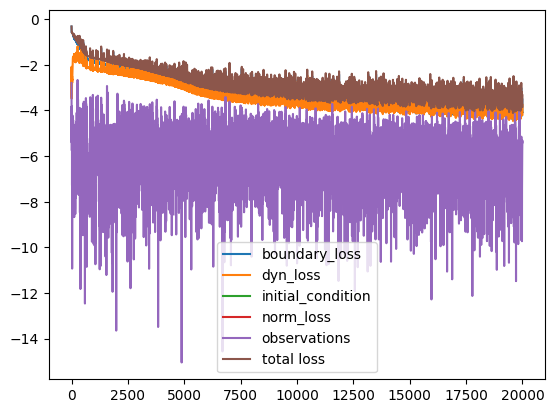

In [16]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

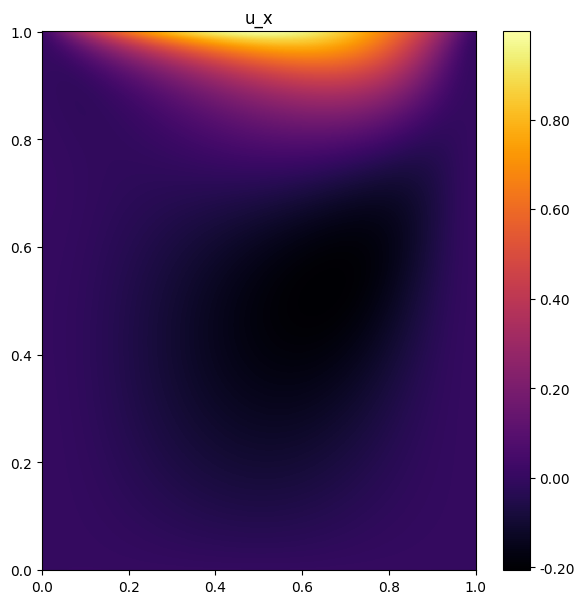

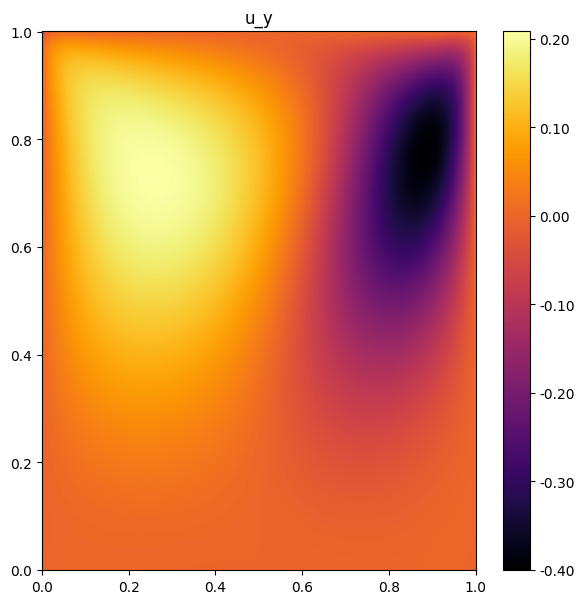

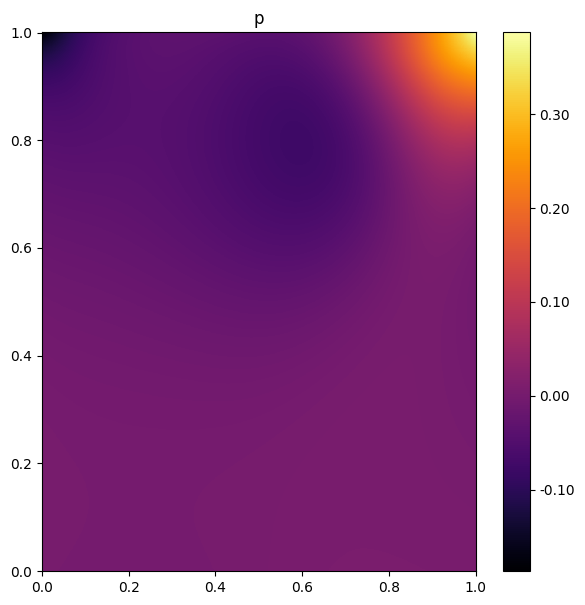

In [17]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

u_x = lambda x: u_pinn(x, params_pinn)[0]
jinns.plot.plot2d(
    fun=u_x,
    xy_data=val_xy_data,
    title="u_x"
)

u_y = lambda x: u_pinn(x, params_pinn)[1]
jinns.plot.plot2d(
    fun=u_y,
    xy_data=val_xy_data,
    title="u_y"
)

p = lambda x: u_pinn(x, params_pinn)[2]
jinns.plot.plot2d(
    fun=p,
    xy_data=val_xy_data,
    title="p"
)

## PINA

In [5]:
from pytorch_lightning import seed_everything

# setting the seed for reproducibility
seed_everything(seed, workers=True)

Seed set to 1


1

In [6]:
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import torch
from pytorch_lightning.callbacks import Callback
from pina.problem import SpatialProblem
from pina.operators import grad, div, laplacian
from pina.model import FeedForward
from pina.equation import Equation, FixedValue, SystemEquation
from pina import Condition, Trainer, LabelTensor
from pina.solvers import PINN
from pina.geometry import CartesianDomain

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
### Define ranges of variables
x_min = 0
x_max = 1
y_min = 0
y_max = 1

p_value_at_0 = torch.zeros((1,)).to(device).float()

class NS2dC(SpatialProblem):

    output_variables = ['ux', 'uy', 'p']

    spatial_domain = CartesianDomain({'x': [x_min, x_max], 'y': [y_min, y_max]})

            
    def NS_equation_x(input_, output_):

        dux_dx = grad(output_, input_, components=['ux'], d=['x'])
        dux_dy = grad(output_, input_, components=['ux'], d=['y'])
        lap_ux = laplacian(output_, input_, components=['ux'], d=['x', 'y'])
        dp_dx = grad(output_, input_, components=['p'], d=['x'])

        return (output_.extract(['ux']) * dux_dx + output_.extract(['uy']) * dux_dy +
            dp_dx - nu * lap_ux)

    def NS_equation_y(input_, output_):

        duy_dx = grad(output_, input_, components=['uy'], d=['x'])
        duy_dy = grad(output_, input_, components=['uy'], d=['y'])
        lap_uy = laplacian(output_, input_, components=['uy'], d=['x', 'y'])
        dp_dy = grad(output_, input_, components=['p'], d=['y'])

        return (output_.extract(['ux']) * duy_dx + output_.extract(['uy']) * duy_dy +
            dp_dy - nu * lap_uy)
        
    def conservation_equation(input_, output_):
        return div(output_, input_, components=['ux', 'uy'], d=['x', 'y'])

    def gamma1_condition_x(input_, output_):
        ux_expected = 4 * input_.extract(['x']) * (1 - input_.extract(['x']))
        return output_.extract(['ux']) - ux_expected

    def gamma1_condition_y(input_, output_):
        return output_.extract(['uy']) #- 0

    def data_equation(input_, output_):
        # Force p to 0 at the origin
        return output_.extract(['p']) - p_value_at_0

    # define the conditions for the loss (boundary conditions, equation, data)
    conditions = {
        'gamma1': Condition(location=CartesianDomain({'x': [x_min, x_max],
            'y':  y_max}),
            equation=SystemEquation([gamma1_condition_x, gamma1_condition_y])),
        # 'gamma1_y': Condition(location=CartesianDomain({'x': [x_min, x_max],
        #     'y':  y_max}),
        #     equation=Equation(gamma1_condition_y)),
        'gamma2': Condition(location=CartesianDomain({'x': [x_min, x_max], 'y': y_min
            }),
            equation=FixedValue(0.)),
        'gamma3': Condition(location=CartesianDomain({'x':  x_max, 'y': [y_min, y_max]
            }),
            equation=FixedValue(0.)),
        'gamma4': Condition(location=CartesianDomain({'x': x_min, 'y': [y_min, y_max]
            }),
            equation=FixedValue(0.)),
        'D': Condition(location=CartesianDomain({'x': [x_min, x_max], 'y': [y_min, y_max]
            }),
        equation=SystemEquation([NS_equation_x, NS_equation_y, conservation_equation])),
        'p': Condition(
            location=CartesianDomain({'x': [x_min, x_max], 'y': [y_min, y_max]
            }),
            equation=Equation(data_equation)
        )
    }

problem = NS2dC()

In [8]:
from math import sqrt
problem.discretise_domain(
    n=int(sqrt(DEFAULT_NUM_DOMAIN_POINTS)), # NOTE the sqrt
    mode='grid',
    variables=['x', 'y'],
    locations='D'
)
problem.discretise_domain(
    n=DEFAULT_NUM_BOUNDARY_POINTS // 4, # divide by 4 since NUM_BOUNDARY is the total
    mode='grid',
    variables=['x', 'y'],
    locations=['gamma1', 'gamma2', 'gamma3', 'gamma4']
)
problem.discretise_domain(
    n=1, # divide by 4 since NUM_BOUNDARY is the total
    mode='grid',
    variables=['x', 'y'],
    locations=['p']
)
print('Input points:', problem.input_pts['D'].shape)
print('Input points:', problem.input_pts['gamma2'].shape)
print('Input points:', problem.input_pts['gamma3'].shape)

print('Input points:', problem.input_pts['gamma1'].shape)
print('Input points:', problem.input_pts['gamma1'].shape)

print('Input points:', problem.input_pts['p'].shape)

Input points: torch.Size([784, 2])
Input points: torch.Size([51, 2])
Input points: torch.Size([51, 2])
Input points: torch.Size([51, 2])
Input points: torch.Size([51, 2])
Input points: torch.Size([1, 2])


In [9]:
from pina import Trainer
from pina.solvers import PINN
from pina.callbacks import MetricTracker, PINAProgressBar
from pytorch_lightning.callbacks import Timer

pbar = PINAProgressBar(metrics=['mean'], refresh_rate=1)


# build the model
model_ = FeedForward(
    layers=[100, 100, 100, 100, 100],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

# create the PINN object
pinn = PINN(
    problem,
    model_,
    optimizer=torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-3}
)

# create the trainer
trainer = Trainer(
    solver=pinn,
    max_epochs=20000,
    callbacks=[MetricTracker(), pbar, Timer()],
    accelerator='gpu',
    enable_model_summary=False,
    log_every_n_steps=1000,
    val_check_interval=1000,
    check_val_every_n_epoch=None,
    enable_checkpointing=False
) 

# train
trainer.train()

print(f'Total training time {trainer.callbacks[-1].time_elapsed("train"):.5f} s')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-12-05 12:12:36.707214: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 12:12:36.715056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733397156.724532   28250 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733397156.727410   28250 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 12:12:36.737354:

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20000` reached.


Total training time 1606.87494 s


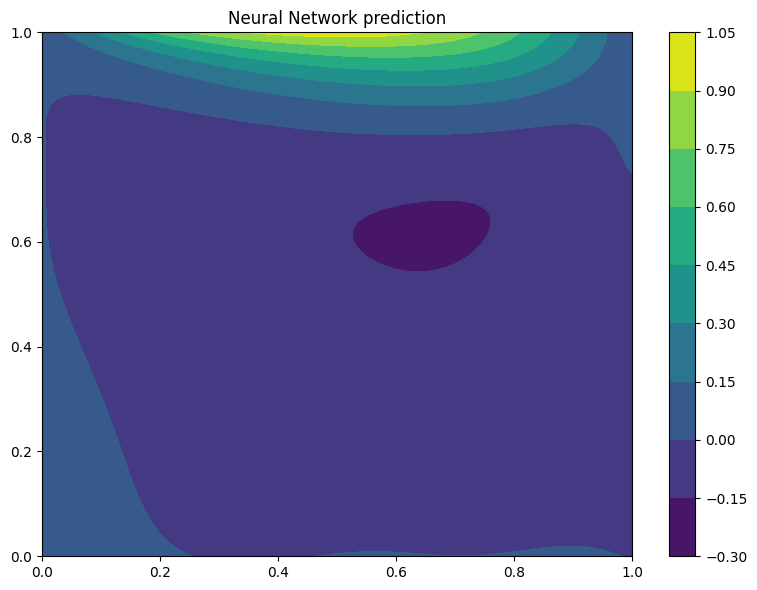

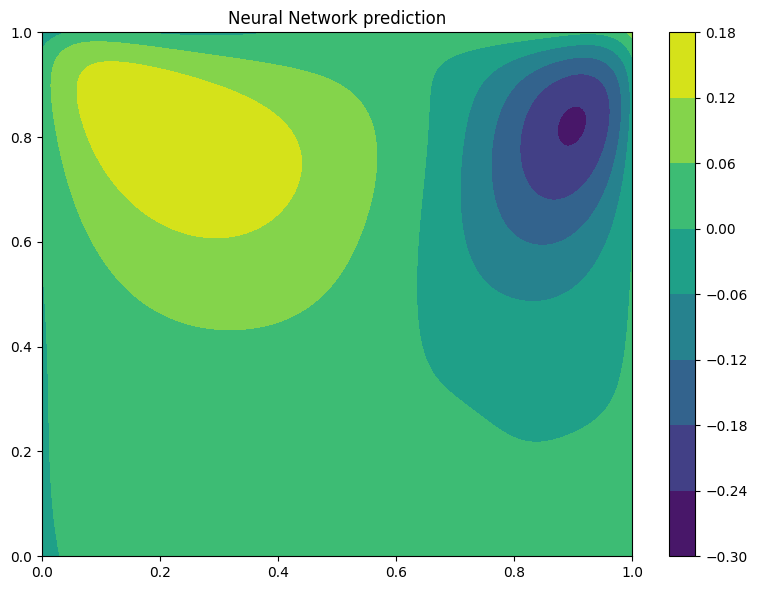

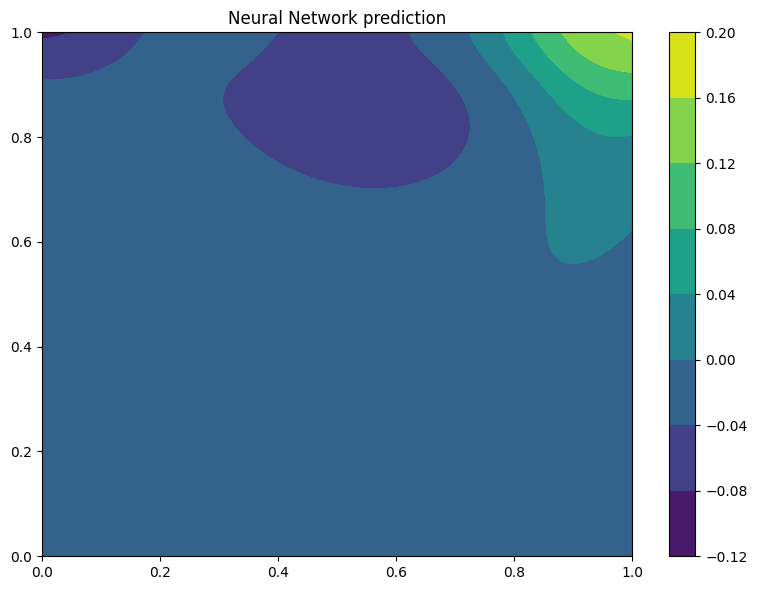

In [10]:
from pina import Plotter

pl = Plotter()
pl.plot(solver=pinn, components=['ux'])
pl.plot(solver=pinn, components=['uy'])
pl.plot(solver=pinn, components=['p'])

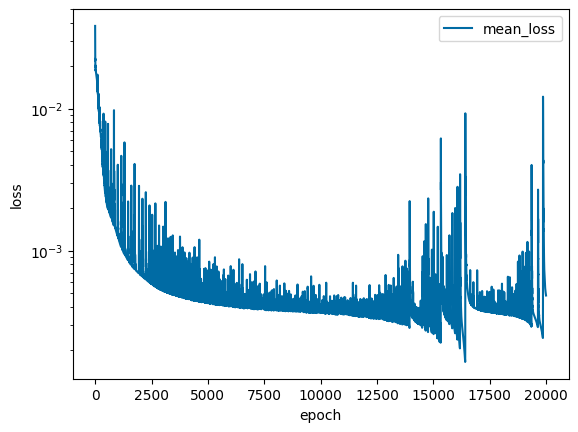

In [11]:
pl.plot_loss(trainer=trainer, label = 'mean_loss', logy=True)

## Comparisons

In [12]:
import sys
sys.path.append('../')

from PINNacle_utils import compute_relative_errors

nan_mask = np.isnan(ref_data).any(axis=1)
test_x = ref_data[~nan_mask, :2]
test_y = ref_data[~nan_mask, 2:]

In [9]:
compute_relative_errors(test_y, model.predict(test_x))

l1re=0.07004419, l2re=0.10553406


In [20]:
pred = jax.vmap(u_pinn, (0, None))(test_x, params_pinn)
compute_relative_errors(test_y, pred)

l1re=0.0315228, l2re=0.06384359


In [13]:
compute_relative_errors(
    test_y,
    pinn(LabelTensor(test_x, ['x', 'y'])).detach().cpu().numpy()
)

l1re=0.38457862, l2re=0.62336135
